In [10]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

import torchvision.transforms as transforms
# from torchvision.transforms import v2
from sklearn.manifold import TSNE

from tqdm import tqdm

In [9]:
import os, sys

project_dir = '/home/alcindo/projeto/swav-cows'
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


In [3]:
directory = '/home/alcindo/projeto/swav-cows/checkpoints/normalized_dataset/10proto/' 

with open(os.path.join(directory, "params.yaml"), 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)

In [4]:
params

{'data': {'crop_sizes': [[208, 576], [208, 576]],
  'max_scales': [1.0, 0.5],
  'min_scales': [1.0, 0.2],
  'n_hr_views': 2,
  'n_lr_views': 0,
  'root_dir': './normalized_dataset/'},
 'training': {'backbone_model': 'resnet18',
  'batch_size': 128,
  'checkpoints_file_path': './checkpoints/',
  'device': 'cuda',
  'learning_rate': 0.0001,
  'max_patience': 10,
  'min_epochs': 150,
  'n_features_swav': 128,
  'n_prototypes': 10,
  'sinkhorn_epsilon': 0.03,
  'weights_file_name': None}}

## Load dataset

In [5]:
from src.dataset import NumpyDataset
from torch.utils.data import DataLoader


dataset = NumpyDataset(os.path.join(params['data']['root_dir']))


dataloader = DataLoader(dataset, batch_size=params['training']['batch_size'], shuffle=True, drop_last=True)
    

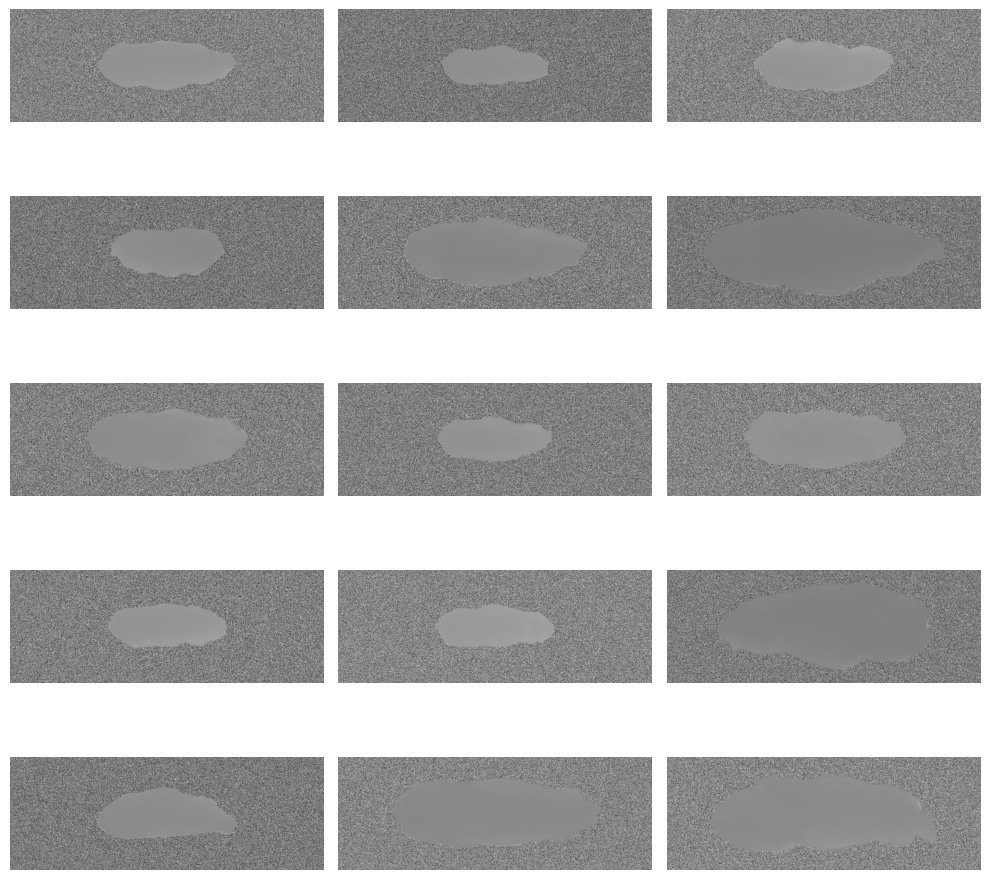

In [6]:
# plot 15 images from dataloader 5x3

for images in dataloader:
    images = images[:15]
    fig, axs = plt.subplots(5, 3, figsize=(10, 10))
    axs = axs.flatten()
    for i in range(len(images)):
        axs[i].imshow(images[i].permute(1, 2, 0).numpy(), cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
    break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from src.model import SwaV

model = SwaV(
    backbone_model  = params['training']['backbone_model'],
    input_size      = params['data']['crop_sizes'][0],
    n_hr_views      = params['data']['n_hr_views'],
    n_prototypes    = params['training']['n_prototypes'],
    n_features_swav = params['training']['n_features_swav'],
    batch_size      = params['training']['batch_size']
).to(device)

model.load_state_dict(torch.load(f"{directory}/minloss.pth", weights_only=True))




<All keys matched successfully>

In [11]:
model.eval()
similarities = []
features = []

with torch.no_grad():

    for img in tqdm(dataset):
        img = img.unsqueeze(0)
        f = model._subforward(img.to(device))[0]
        p = model.prototypes(f, step=2)
        features.append(f.to('cpu'))
        similarities.append(p.to('cpu'))


100%|██████████| 16556/16556 [00:29<00:00, 556.66it/s]


In [12]:

features = torch.vstack(features)
similarities = torch.vstack(similarities)
confidence, proto_assign = torch.max(torch.softmax(similarities, dim=-1), dim=-1)

swav_prototypes = model.prototypes.heads[0].weight.cpu().detach()


In [13]:
features

tensor([[-0.0853,  0.0630,  0.0946,  ..., -0.0492, -0.0856, -0.1304],
        [-0.0276,  0.1342, -0.0074,  ...,  0.0370,  0.0430, -0.1843],
        [ 0.0676,  0.0148, -0.0711,  ...,  0.1486,  0.0347,  0.0825],
        ...,
        [ 0.0087,  0.0876, -0.0662,  ...,  0.0730, -0.1071,  0.1418],
        [-0.0281,  0.1383, -0.0088,  ...,  0.0356,  0.0440, -0.1851],
        [ 0.0424,  0.0774, -0.0733,  ...,  0.1541,  0.0473,  0.0139]])

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_nd = torch.concat([features, swav_prototypes], axis=0)
tsne_2d = tsne.fit_transform(tsne_nd)

n_projs = len(features)
proj_2d, prot_2d = tsne_2d[:n_projs, :], tsne_2d[n_projs:, :]



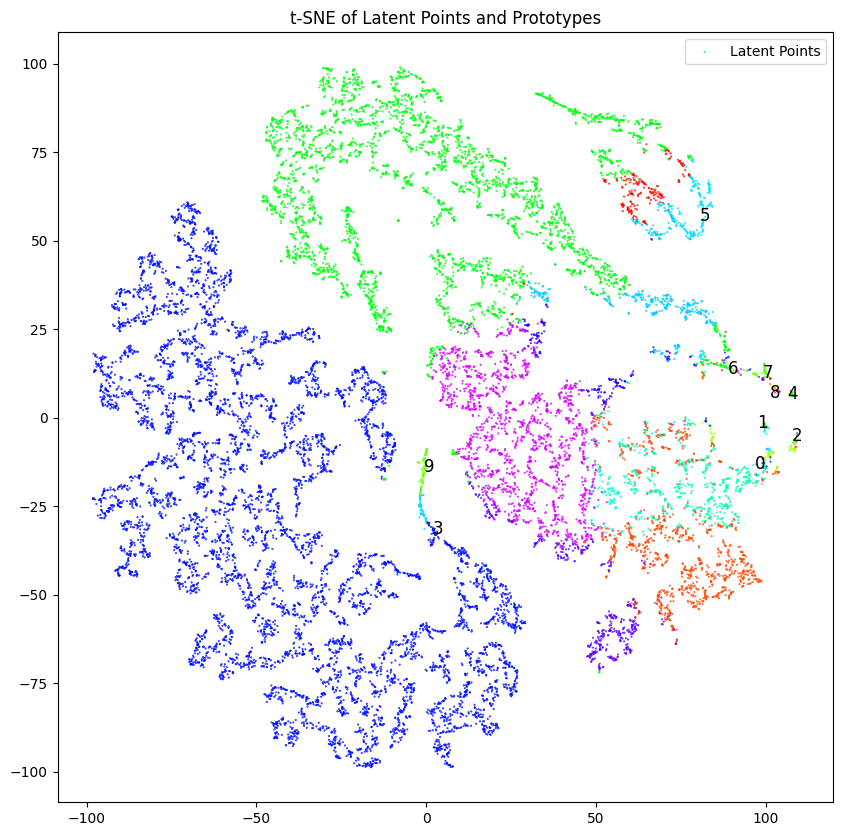

In [15]:
# Plot the TSNE results
cluster_labels = features.argmax(axis=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
# plt.scatter(tsne_prot[:, 0], tsne_prot[:, 1], c='black', label='Prototypes', marker='.')
for i, (x, y) in enumerate(prot_2d):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()